# Google Search Terms

This notebook is for Exploratory Data Analysis for search data from Google Trends.  
The following data is collected.  


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


# Import Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

2023-04-09 10:07:15.119507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 10:07:15.607523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-04-09 10:07:17.397759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 10:07:17.417102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 10:07:17.417182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
df_part_1 = pd.read_csv('../assets/dengue_part_1.csv')
df_part_2 = pd.read_csv('../assets/dengue_part_2.csv')

In [4]:
df_part_1.loc[df_part_1['Week']=='8/11/2015']

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
128,8/11/2015,6,5,7,1


For Google Trend data, including a prolonged period of time will cause the data to be automatically compressed to monthly format from weekly format.   
Hence the search data are collected as 2 parts.  
They have overlapping dates and also the same highest search week.   
This ensure that all data are scaled the same way.   

In [5]:
df_part_1 = df_part_1.iloc[:128,:]
df_part_1.tail()

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
123,4/10/2015,7,7,6,1
124,11/10/2015,6,4,6,3
125,18/10/2015,7,6,7,1
126,25/10/2015,6,6,5,1
127,1/11/2015,8,6,6,1


In [6]:
df = pd.concat([df_part_1, df_part_2])
df.iloc[127:133,:]

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
127,1/11/2015,8,6,6,1
0,8/11/2015,6,5,7,1
1,15/11/2015,7,6,7,3
2,22/11/2015,7,6,6,2
3,29/11/2015,6,6,7,2
4,6/12/2015,7,7,5,2


In [7]:
df.reset_index(inplace=True, drop=True)
df.iloc[126:133,:]

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
126,25/10/2015,6,6,5,1
127,1/11/2015,8,6,6,1
128,8/11/2015,6,5,7,1
129,15/11/2015,7,6,7,3
130,22/11/2015,7,6,6,2
131,29/11/2015,6,6,7,2
132,6/12/2015,7,7,5,2


In [8]:
# Check if there are null values
df.isnull().sum()

Week                             0
Dengue fever: (Singapore)        0
Dengue: (Singapore)              0
Mosquito: (Singapore)            0
Insect repellent: (Singapore)    0
dtype: int64

In [9]:
display(len(df))

389

In [10]:
# Change the 1st column to date time format
df['Week'] = pd.to_datetime(df['Week'], dayfirst=True);
# Convert datetime to intended string format
df['Week'] = df['Week'].dt.strftime('%Y-%m-%d')
#display df
df.head()

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
0,2013-05-26,33,30,10,2
1,2013-06-02,29,28,9,3
2,2013-06-09,56,52,18,4
3,2013-06-16,42,39,14,2
4,2013-06-23,25,23,8,2


In [11]:
df.loc[df['Mosquito: (Singapore)']==100]

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
170,2016-08-28,17,16,100,57


In [12]:
df.loc[df['Insect repellent: (Singapore)']=='<1']

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
13,2013-08-25,11,11,7,<1
179,2016-10-30,5,4,7,<1
273,2018-08-19,4,3,6,<1


In [13]:
df['Insect repellent: (Singapore)'].replace('<1', 1, inplace=True)

In [14]:
df.loc[df['Insect repellent: (Singapore)']=='<1']

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)


In [15]:
df.loc[df['Dengue: (Singapore)']=='<1']

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)


In [16]:
df.loc[df['Dengue fever: (Singapore)']=='<1']

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)


In [17]:
df.loc[df['Mosquito: (Singapore)']=='<1']

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)


In [18]:
df_int = df.iloc[:,1:5].astype(int)

In [19]:
df_int.head()

,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
0,33,30,10,2
1,29,28,9,3
2,56,52,18,4
3,42,39,14,2
4,25,23,8,2


In [20]:
df.drop(columns=['Dengue fever: (Singapore)', 'Dengue: (Singapore)', 'Mosquito: (Singapore)', 'Insect repellent: (Singapore)'],inplace=True)
df = pd.concat([df, df_int], axis=1)
df.head()

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
0,2013-05-26,33,30,10,2
1,2013-06-02,29,28,9,3
2,2013-06-09,56,52,18,4
3,2013-06-16,42,39,14,2
4,2013-06-23,25,23,8,2


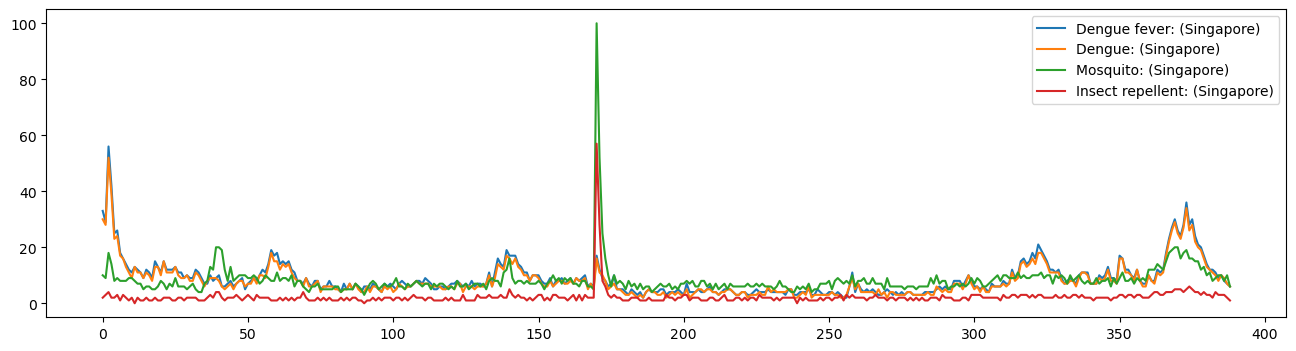

In [21]:
# Plot the original trend
fig = plt.figure(figsize=(16,4))
plt.plot(df.index, df.iloc[:,1:5]);
plt.legend(['Dengue fever: (Singapore)', 'Dengue: (Singapore)', 'Mosquito: (Singapore)', 'Insect repellent: (Singapore)']);

In [22]:
# 1 month is approximately 4 weeks. Hence rolling window of 4.
df_roll_4 = df.iloc[:,1:5].rolling(4).mean()

In [23]:
df_roll_4.head()

,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,40.0,37.25,12.75,2.75
4,38.0,35.50,12.25,2.75


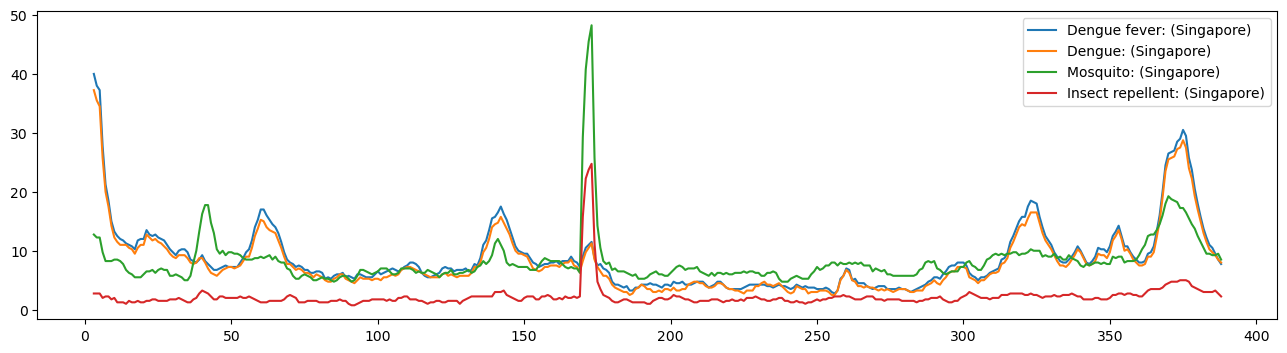

In [24]:
# Plot the trend for rolling window of 4 days
fig = plt.figure(figsize=(16,4))
plt.plot(df_roll_4.index, df_roll_4);
plt.legend(['Dengue fever: (Singapore)', 'Dengue: (Singapore)', 'Mosquito: (Singapore)', 'Insect repellent: (Singapore)']);

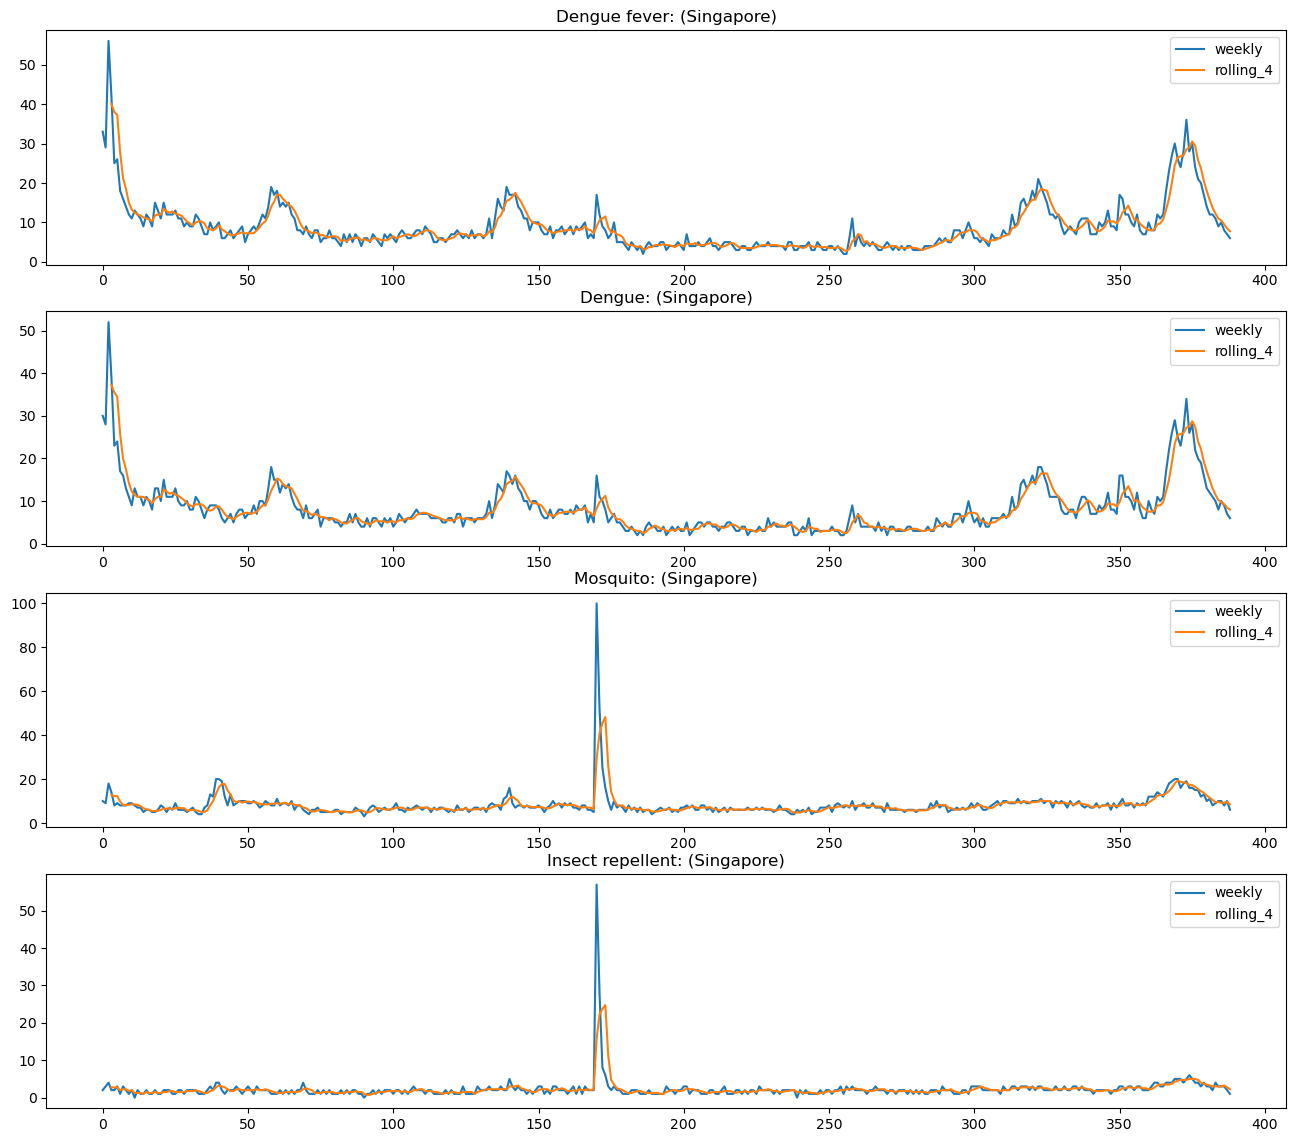

In [25]:
# compare rolling_4 and actual weekly
title_list = ['Dengue fever: (Singapore)', 'Dengue: (Singapore)', 'Mosquito: (Singapore)', 'Insect repellent: (Singapore)']
fig, axes = plt.subplots(nrows=4, figsize=(16,14))
for i, col_name in enumerate(title_list):
    axes[i].plot(df[col_name]);
    axes[i].plot(df[col_name].rolling(4).mean());
    axes[i].legend(['weekly','rolling_4'])
    axes[i].title.set_text(col_name)

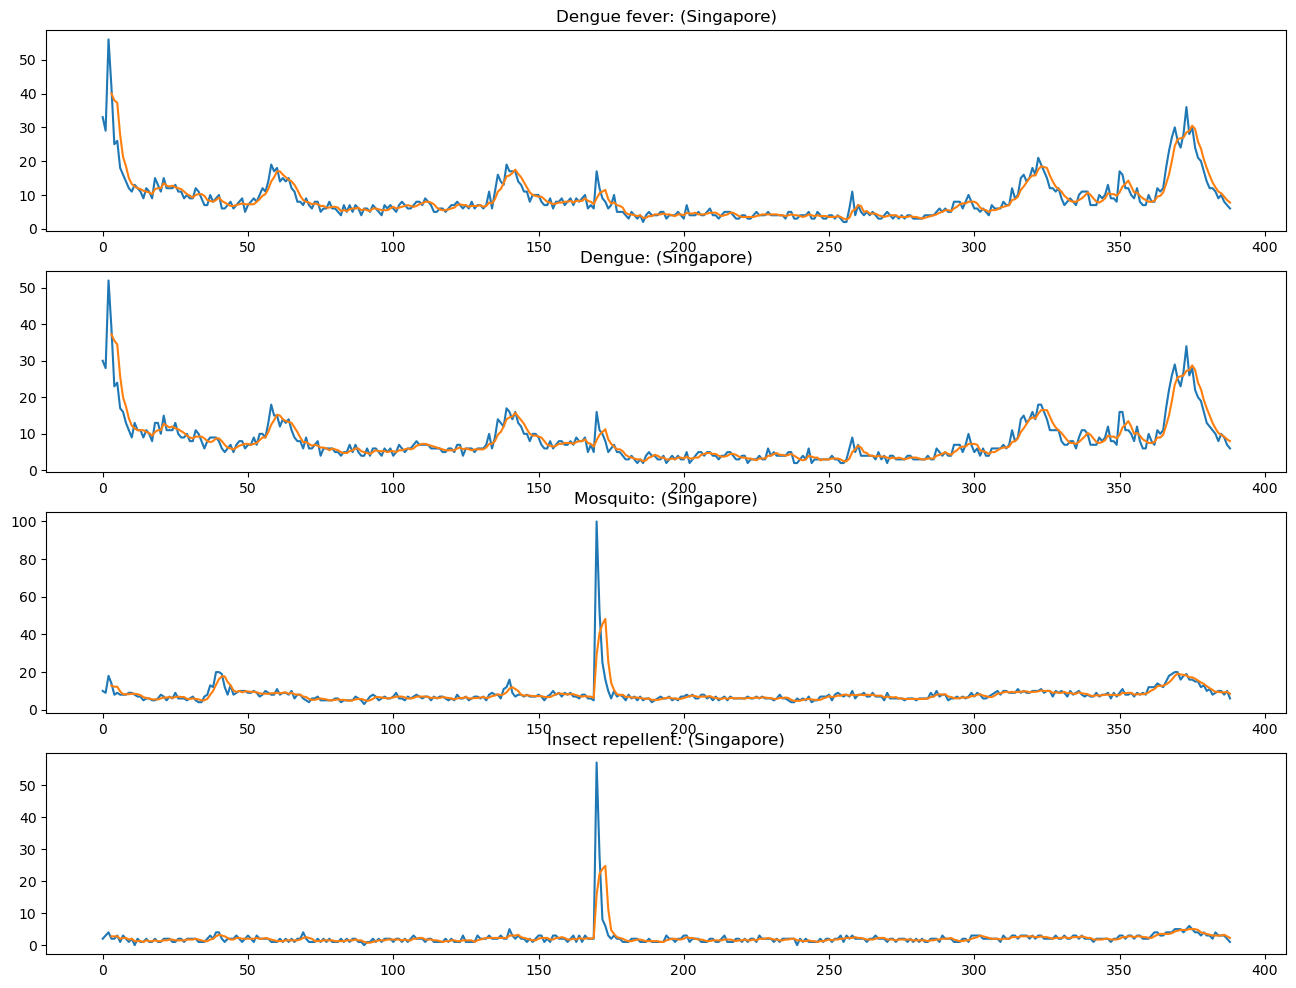

In [26]:
fig, axes = plt.subplots(nrows=4, figsize=(16,12))
for i, col_name in enumerate(title_list):
    axes[i].plot(df[col_name]);
    axes[i].plot(df[col_name].rolling(4).mean());
    axes[i].title.set_text(col_name)

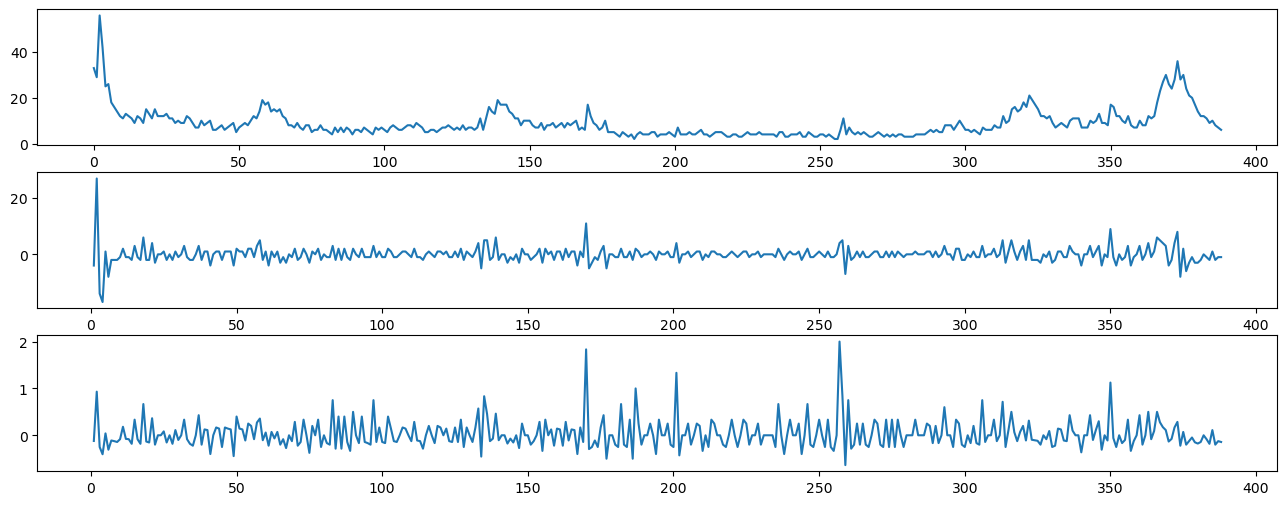

In [27]:
# The diff and % changes for Dengue Fever (Diesease)
fig, axes = plt.subplots(nrows=3, figsize=(16,6))
axes[0].plot(df.iloc[:,1]);
axes[1].plot(df.iloc[:,1].diff());
axes[2].plot(df.iloc[:,1].pct_change());

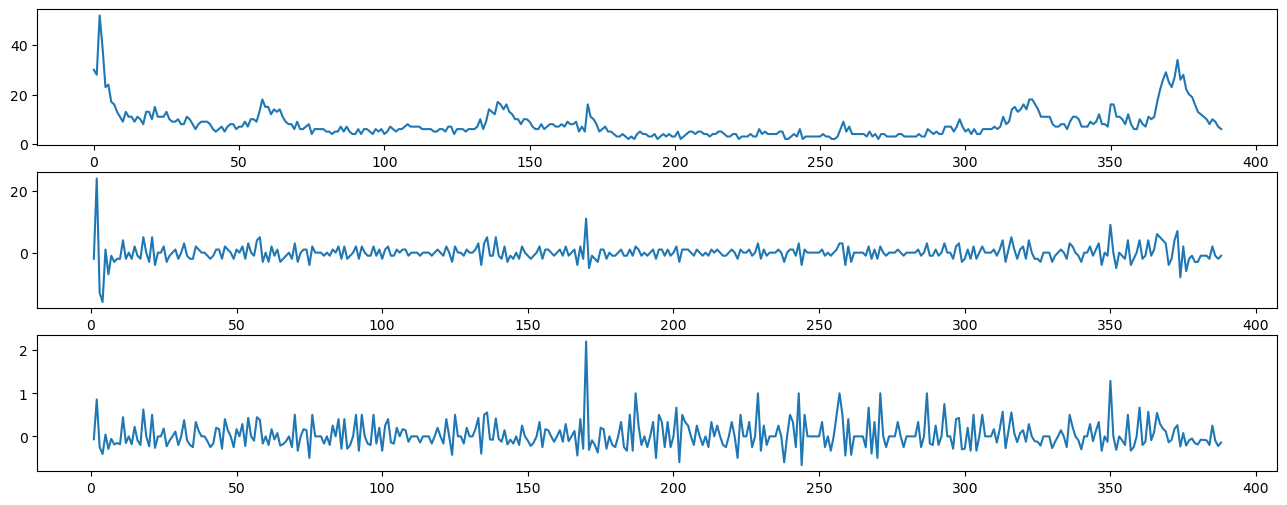

In [28]:
# The diff and % changes for Dengue (Search Term)
fig, axes = plt.subplots(nrows=3, figsize=(16,6))
axes[0].plot(df.iloc[:,2]);
axes[1].plot(df.iloc[:,2].diff());
axes[2].plot(df.iloc[:,2].pct_change());

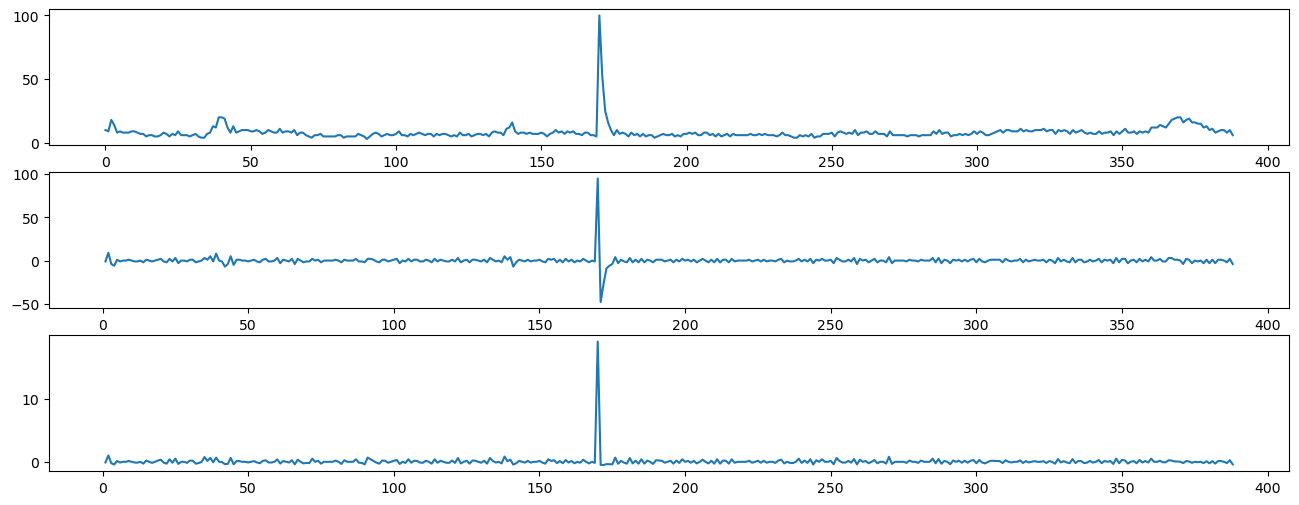

In [29]:
# The diff and % changes for Mosquito (Insect)
fig, axes = plt.subplots(nrows=3, figsize=(16,6))
axes[0].plot(df.iloc[:,3]);
axes[1].plot(df.iloc[:,3].diff());
axes[2].plot(df.iloc[:,3].pct_change());

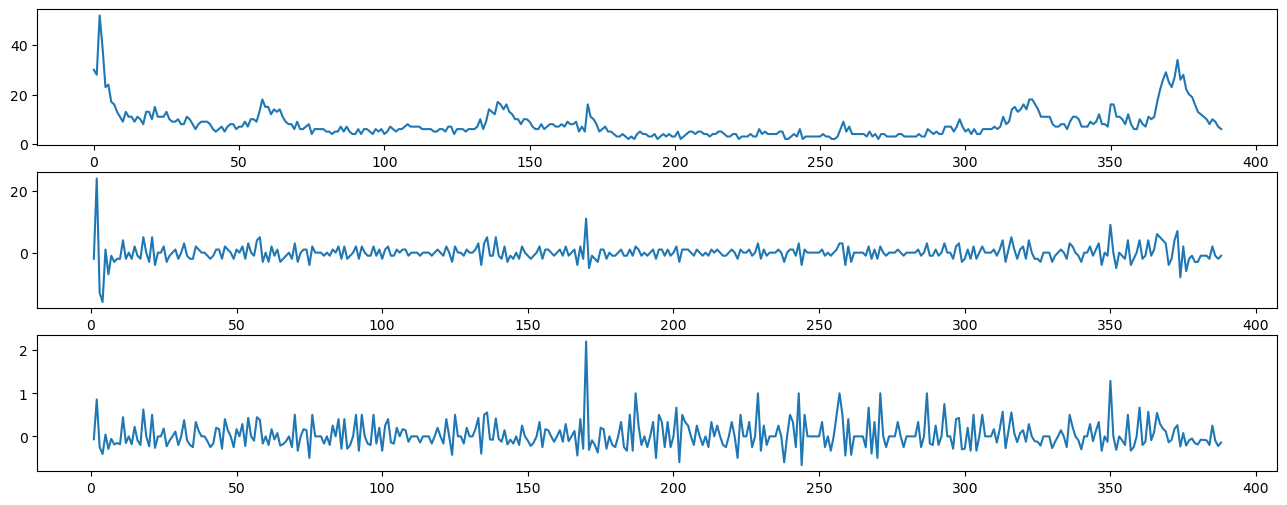

In [30]:
# The diff and % changes for Insect repellent (Search Term)
fig, axes = plt.subplots(nrows=3, figsize=(16,6))
axes[0].plot(df.iloc[:,2]);
axes[1].plot(df.iloc[:,2].diff());
axes[2].plot(df.iloc[:,2].pct_change());

In [31]:
#Look at the diff and .diff().diff()
for col_title in title_list:
    df[col_title+'diff'] = df[col_title].diff()
    df[col_title+'2nd_diff'] = df[col_title].diff().diff()

In [32]:
df.head()

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore),Dengue fever: (Singapore)diff,Dengue fever: (Singapore)2nd_diff,Dengue: (Singapore)diff,Dengue: (Singapore)2nd_diff,Mosquito: (Singapore)diff,Mosquito: (Singapore)2nd_diff,Insect repellent: (Singapore)diff,Insect repellent: (Singapore)2nd_diff
0,2013-05-26,33,30,10,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-06-02,29,28,9,3,-4.0,NaN,-2.0,NaN,-1.0,NaN,1.0,NaN
2,2013-06-09,56,52,18,4,27.0,31.0,24.0,26.0,9.0,10.0,1.0,0.0
3,2013-06-16,42,39,14,2,-14.0,-41.0,-13.0,-37.0,-4.0,-13.0,-2.0,-3.0
4,2013-06-23,25,23,8,2,-17.0,-3.0,-16.0,-3.0,-6.0,-2.0,0.0,2.0


In [33]:
name_list = ['Week', 'Dengue fever: (Singapore)', 'Dengue: (Singapore)', 'Mosquito: (Singapore)', 'Insect repellent: (Singapore)',
             'Dengue fever: (Singapore)diff', 'Dengue: (Singapore)diff', 'Mosquito: (Singapore)diff', 'Insect repellent: (Singapore)diff',
             'Dengue fever: (Singapore)2nd_diff', 'Dengue: (Singapore)2nd_diff', 'Mosquito: (Singapore)2nd_diff', 'Insect repellent: (Singapore)2nd_diff',]
rename_list = ['week', 'dengue_fever', 'dengue', 'mosquito', 'insect_repellent',
               'dengue_fever_diff', 'dengue_diff', 'mosquito_diff', 'insect_repellent_diff',
               'dengue_fever_2nd_diff', 'dengue_2nd_diff', 'mosquito_2nd_diff', 'insect_repellent_2nd_diff']
name_dict = {}
for i, name in enumerate(name_list):
    name_dict[name] = rename_list[i]

In [34]:
df_copy = df.rename(columns=name_dict)

In [35]:
df_copy.head()

,week,dengue_fever,dengue,mosquito,insect_repellent,dengue_fever_diff,dengue_fever_2nd_diff,dengue_diff,dengue_2nd_diff,mosquito_diff,mosquito_2nd_diff,insect_repellent_diff,insect_repellent_2nd_diff
0,2013-05-26,33,30,10,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-06-02,29,28,9,3,-4.0,NaN,-2.0,NaN,-1.0,NaN,1.0,NaN
2,2013-06-09,56,52,18,4,27.0,31.0,24.0,26.0,9.0,10.0,1.0,0.0
3,2013-06-16,42,39,14,2,-14.0,-41.0,-13.0,-37.0,-4.0,-13.0,-2.0,-3.0
4,2013-06-23,25,23,8,2,-17.0,-3.0,-16.0,-3.0,-6.0,-2.0,0.0,2.0


In [36]:
df_copy.to_csv('../data/cleaned_google_data.csv')

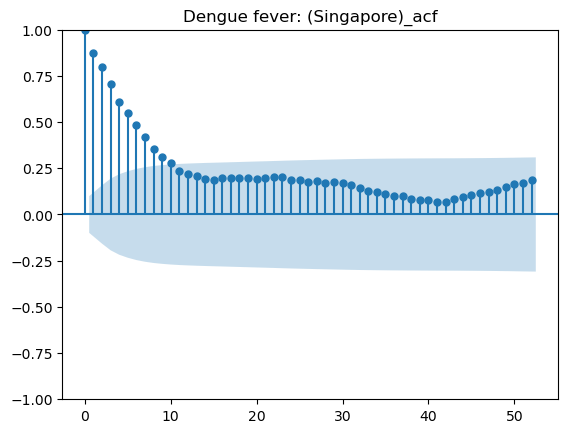

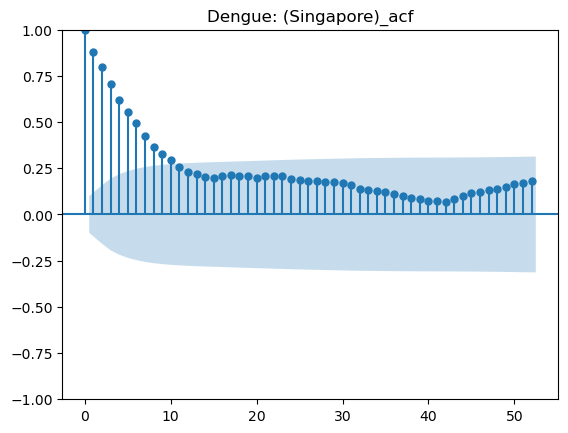

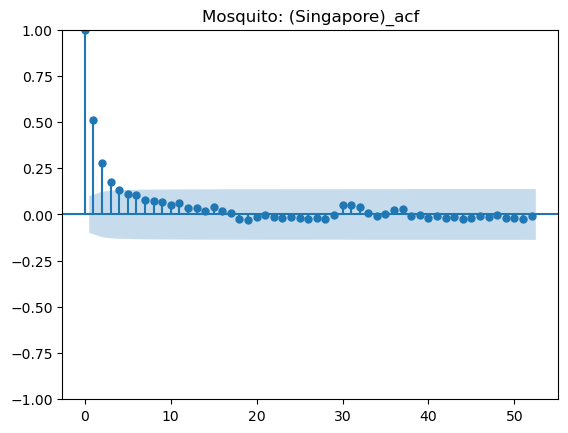

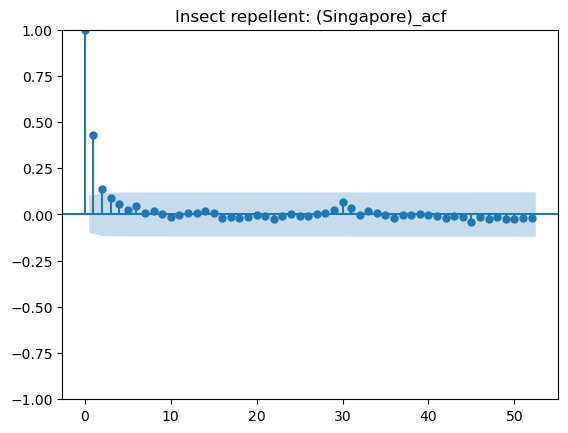

In [37]:
for col_title in title_list:
    # Generate autocorrelation plot on training data.
    plot_acf(df[col_title], lags = 52, title=col_title+'_acf');

/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


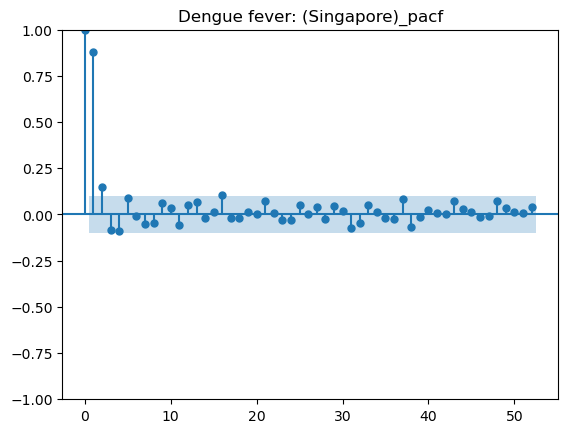

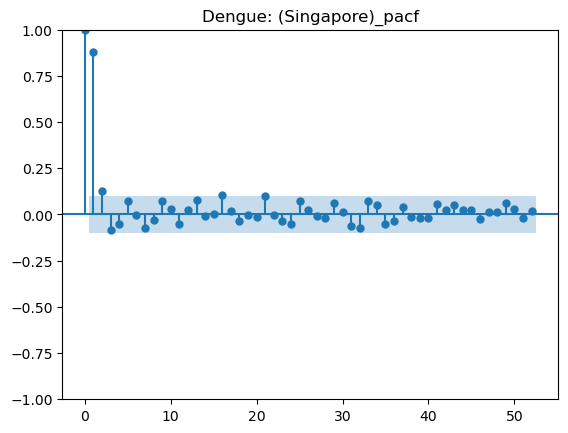

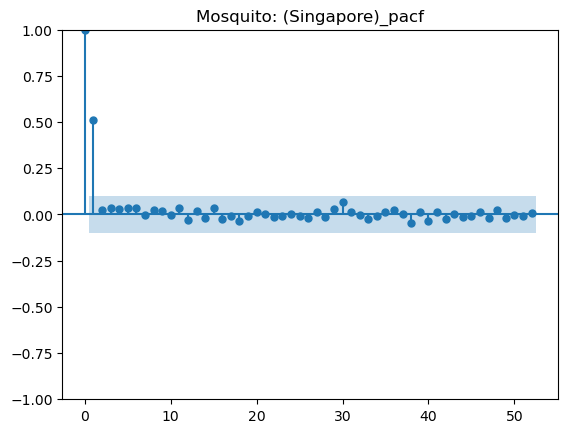

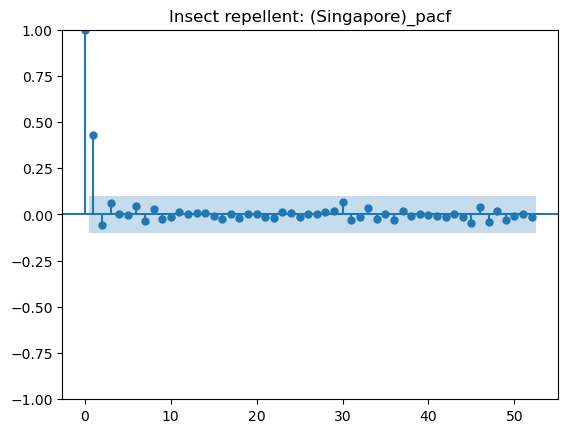

In [38]:
for col_title in title_list:
    # Generate autocorrelation plot on training data.
    plot_pacf(df[col_title], lags = 52, title=col_title+'_pacf');

In [39]:
for col_title in title_list:
    test_res = adfuller(df[col_title])
    print('Augmented Dickey-Fuller Test for '+col_title+": ")
    print('Test Statistic: '+ str(test_res[0]))
    print('Test Statistic: '+ str(test_res[1]))
    print("")

Augmented Dickey-Fuller Test for Dengue fever: (Singapore): 
Test Statistic: -3.5782175391948243
Test Statistic: 0.0061913793405563985

Augmented Dickey-Fuller Test for Dengue: (Singapore): 
Test Statistic: -3.600521485494804
Test Statistic: 0.005751065890620523

Augmented Dickey-Fuller Test for Mosquito: (Singapore): 
Test Statistic: -11.1489757253213
Test Statistic: 2.9765282932002934e-20

Augmented Dickey-Fuller Test for Insect repellent: (Singapore): 
Test Statistic: -12.401591334620479
Test Statistic: 4.548003515160289e-23



# 1st diff

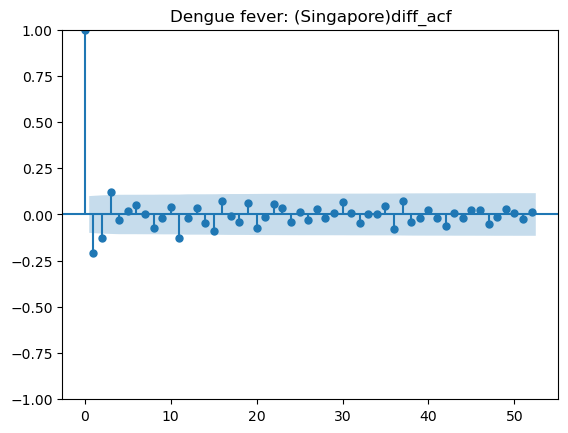

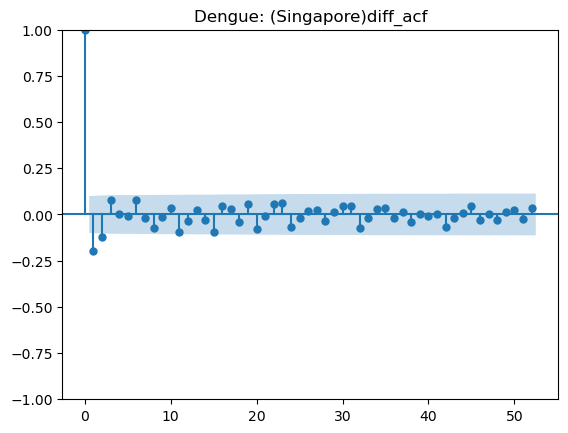

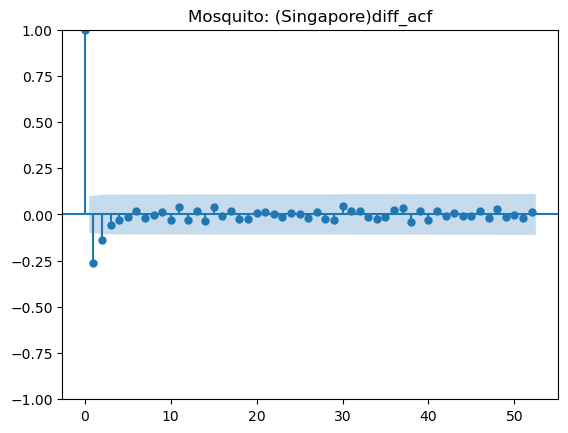

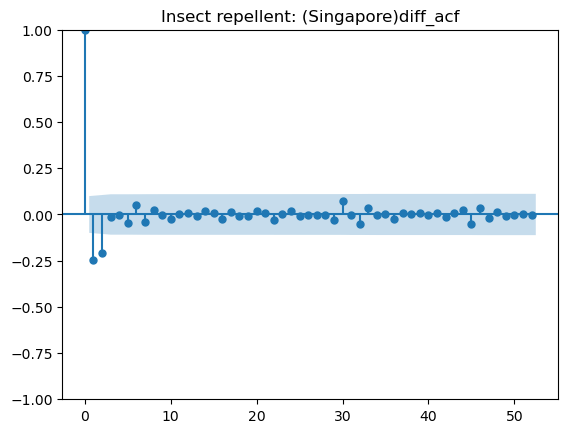

In [40]:
title_list_2 = ['Dengue fever: (Singapore)diff', 'Dengue: (Singapore)diff', 'Mosquito: (Singapore)diff', 'Insect repellent: (Singapore)diff']
for col_title in title_list_2:
    # Generate autocorrelation plot on training data.
    plot_acf(df[col_title].dropna(), lags = 52, title=col_title+'_acf');

/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


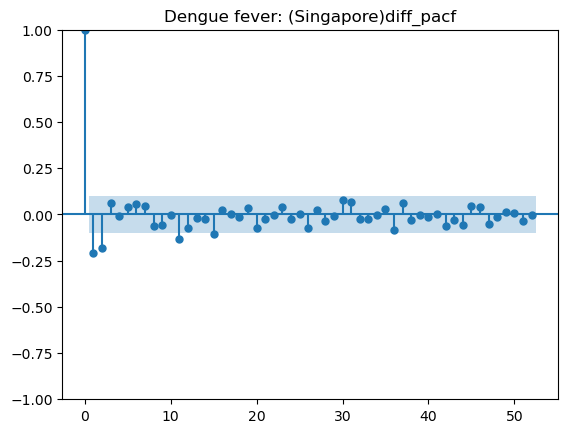

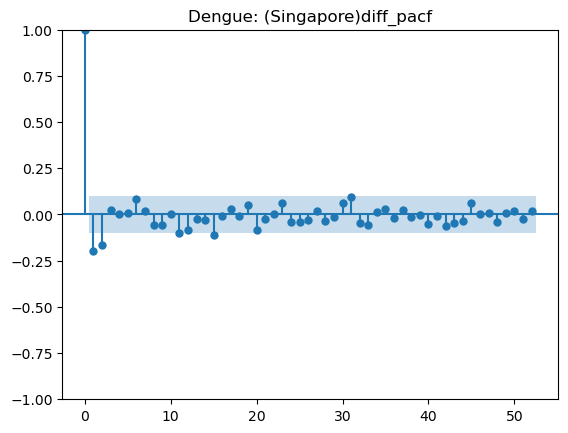

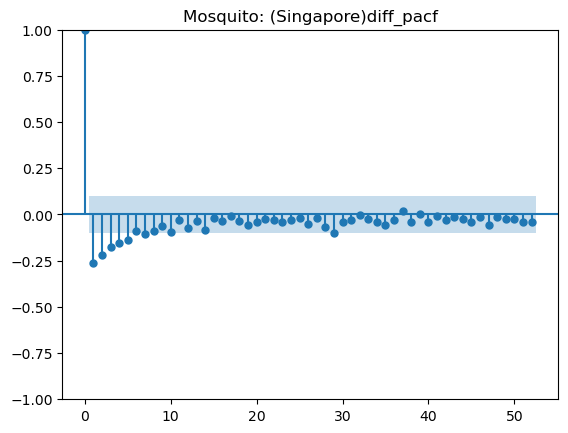

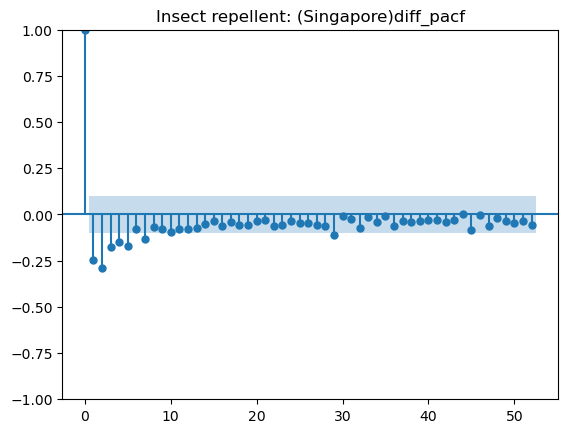

In [41]:
for col_title in title_list_2:
    # Generate autocorrelation plot on training data.
    plot_pacf(df[col_title].dropna(), lags = 52, title=col_title+'_pacf');

In [42]:
for col_title in title_list_2:
    test_res = adfuller(df[col_title].dropna())
    print('Augmented Dickey-Fuller Test for '+col_title+": ")
    print('Test Statistic: '+ str(test_res[0]))
    print('Test Statistic: '+ str(test_res[1]))
    print("")

Augmented Dickey-Fuller Test for Dengue fever: (Singapore)diff: 
Test Statistic: -7.042471728178206
Test Statistic: 5.798979549987971e-10

Augmented Dickey-Fuller Test for Dengue: (Singapore)diff: 
Test Statistic: -7.02175890355448
Test Statistic: 6.515991370124067e-10

Augmented Dickey-Fuller Test for Mosquito: (Singapore)diff: 
Test Statistic: -9.597621067487534
Test Statistic: 1.9590283119708165e-16

Augmented Dickey-Fuller Test for Insect repellent: (Singapore)diff: 
Test Statistic: -9.341869612430798
Test Statistic: 8.752956039957736e-16



# 2nd diff

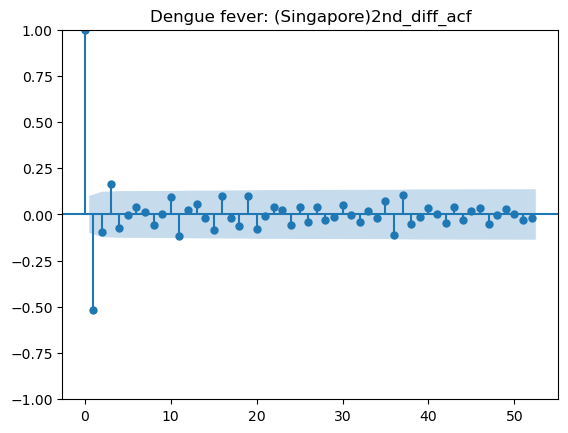

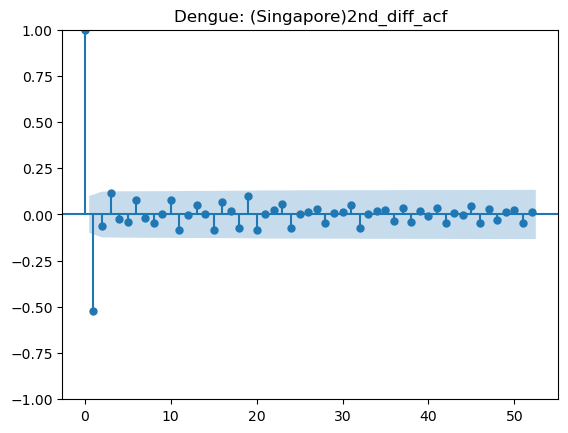

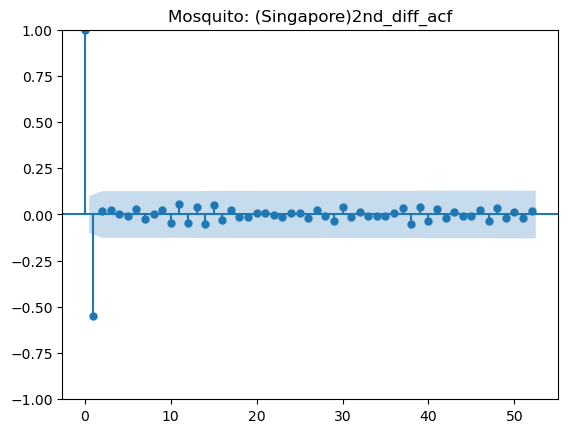

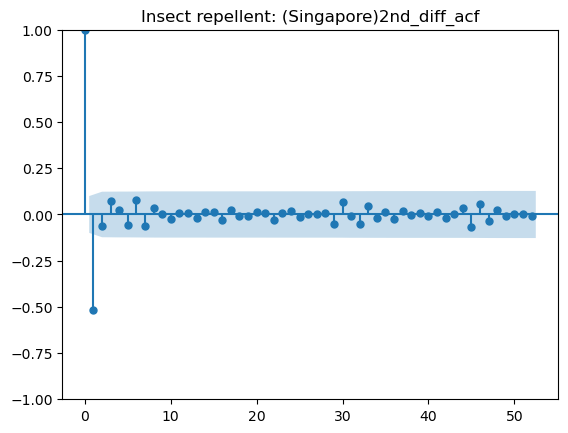

In [44]:
title_list_3 = ['Dengue fever: (Singapore)2nd_diff', 'Dengue: (Singapore)2nd_diff', 'Mosquito: (Singapore)2nd_diff', 'Insect repellent: (Singapore)2nd_diff']
for col_title in title_list_3:
    # Generate autocorrelation plot on training data.
    plot_acf(df[col_title].dropna(), lags = 52, title=col_title+'_acf');

/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


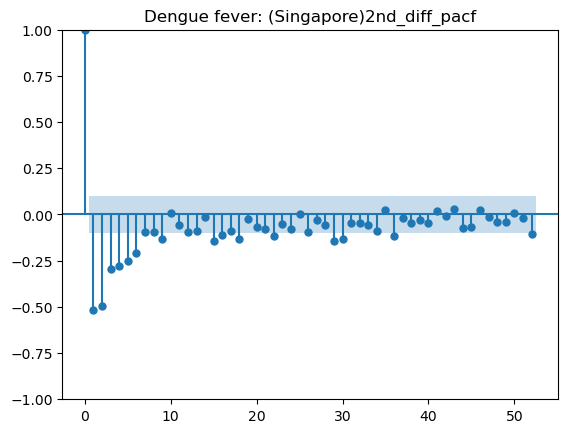

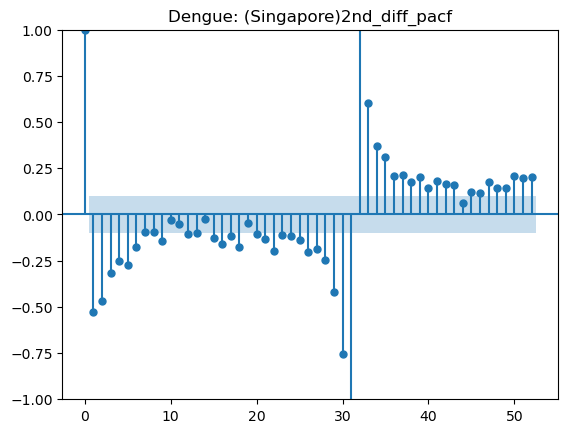

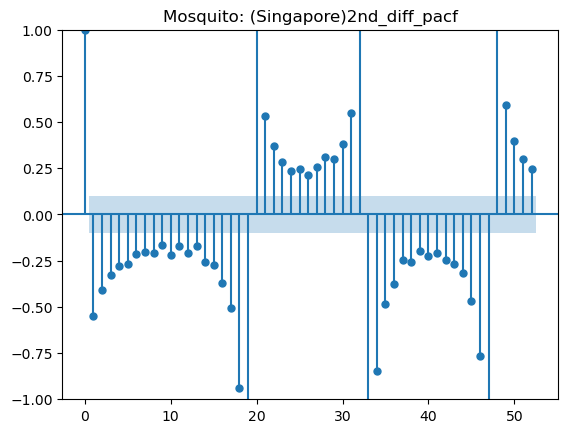

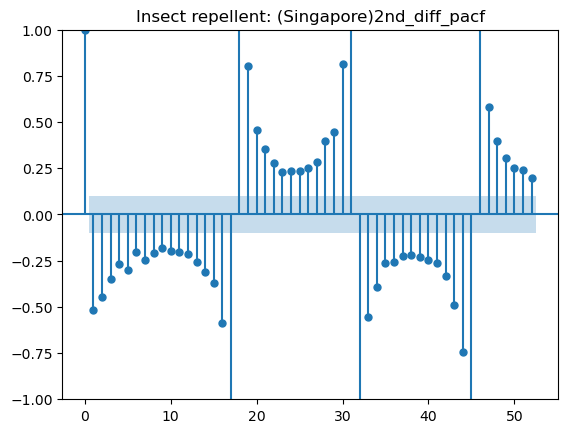

In [45]:
for col_title in title_list_3:
    # Generate autocorrelation plot on training data.
    plot_pacf(df[col_title].dropna(), lags = 52, title=col_title+'_pacf');

In [46]:
for col_title in title_list_3:
    test_res = adfuller(df[col_title].dropna())
    print('Augmented Dickey-Fuller Test for '+col_title+": ")
    print('Test Statistic: '+ str(test_res[0]))
    print('Test Statistic: '+ str(test_res[1]))
    print("")

Augmented Dickey-Fuller Test for Dengue fever: (Singapore)2nd_diff: 
Test Statistic: -9.003556308469703
Test Statistic: 6.400952266986164e-15

Augmented Dickey-Fuller Test for Dengue: (Singapore)2nd_diff: 
Test Statistic: -9.276217690567366
Test Statistic: 1.2868844192159838e-15

Augmented Dickey-Fuller Test for Mosquito: (Singapore)2nd_diff: 
Test Statistic: -9.78300151638793
Test Statistic: 6.656166139093683e-17

Augmented Dickey-Fuller Test for Insect repellent: (Singapore)2nd_diff: 
Test Statistic: -9.381008896585124
Test Statistic: 6.957490705839229e-16



In [30]:
# Create train-test split.
y_train, y_test = train_test_split(df['Dengue fever: (Singapore)'], test_size=.1, shuffle=False)

In [31]:
def grid_ARIMA(y_train, ini_i=1, ini_p=0, ini_q=0, iterations=5):
    # Starting AIC, p, and q.
    best_aic = 99 * (10 ** 16)
    best_p = ini_p
    best_q = ini_q
    i = ini_i

    # Use nested for loop to iterate over values of p and q.
    for p in range(iterations):
        for q in range(iterations):

            # Insert try and except statements.
            try:

                # Fitting an ARIMA(p, 1, q) model.
                print(f'Attempting ARIMA({p}, {i}, {q})')

                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order=(p, i, q));


                # Fit ARIMA model.
                model = arima.fit();

                # Print out AIC for ARIMA(p, 1, q) model.
                print(f'The AIC for ARIMA({p},{i},{q}) is: {model.aic}')

                # Is my current model's AIC better than our best_aic?
                if model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_q = q

            except:
                pass
    print()
    print()
    print('MODEL FINISHED!')
    print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},{i},{best_q}).')
    print(f'This model has an AIC of {best_aic}.')

In [46]:
grid_ARIMA(y_train, ini_i=1)

Attempting ARIMA(0, 1, 0)
The AIC for ARIMA(0,1,0) is: 1717.062819269359
Attempting ARIMA(0, 1, 1)
The AIC for ARIMA(0,1,1) is: 1691.9147509203467
Attempting ARIMA(0, 1, 2)
The AIC for ARIMA(0,1,2) is: 1693.914318320105
Attempting ARIMA(0, 1, 3)
The AIC for ARIMA(0,1,3) is: 1695.889102558086
Attempting ARIMA(0, 1, 4)
The AIC for ARIMA(0,1,4) is: 1697.775890438088
Attempting ARIMA(1, 1, 0)
The AIC for ARIMA(1,1,0) is: 1694.9144974113215
Attempting ARIMA(1, 1, 1)
The AIC for ARIMA(1,1,1) is: 1693.914290636212
Attempting ARIMA(1, 1, 2)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(1,1,2) is: 1695.9143155722627
Attempting ARIMA(1, 1, 3)
The AIC for ARIMA(1,1,3) is: 1695.3331143296791
Attempting ARIMA(1, 1, 4)
The AIC for ARIMA(1,1,4) is: 1696.5848496153326
Attempting ARIMA(2, 1, 0)
The AIC for ARIMA(2,1,0) is: 1694.5783531352238
Attempting ARIMA(2, 1, 1)
The AIC for ARIMA(2,1,1) is: 1695.8916175956474
Attempting ARIMA(2, 1, 2)
The AIC for ARIMA(2,1,2) is: 1695.54188511018
Attempting ARIMA(2, 1, 3)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(2,1,3) is: 1691.622683219291
Attempting ARIMA(2, 1, 4)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(2,1,4) is: 1693.9820874693196
Attempting ARIMA(3, 1, 0)
The AIC for ARIMA(3,1,0) is: 1695.6689032003897
Attempting ARIMA(3, 1, 1)
The AIC for ARIMA(3,1,1) is: 1694.6225724326912
Attempting ARIMA(3, 1, 2)
The AIC for ARIMA(3,1,2) is: 1696.46942139483
Attempting ARIMA(3, 1, 3)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(3,1,3) is: 1693.1433176497496
Attempting ARIMA(3, 1, 4)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(3,1,4) is: 1699.433383612936
Attempting ARIMA(4, 1, 0)
The AIC for ARIMA(4,1,0) is: 1697.5083081948999
Attempting ARIMA(4, 1, 1)
The AIC for ARIMA(4,1,1) is: 1696.5732026630576
Attempting ARIMA(4, 1, 2)
The AIC for ARIMA(4,1,2) is: 1693.4995636384874
Attempting ARIMA(4, 1, 3)
The AIC for ARIMA(4,1,3) is: 1694.07710638601
Attempting ARIMA(4, 1, 4)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(4,1,4) is: 1696.4468807985277


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(2,1,3).
This model has an AIC of 1691.622683219291.


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


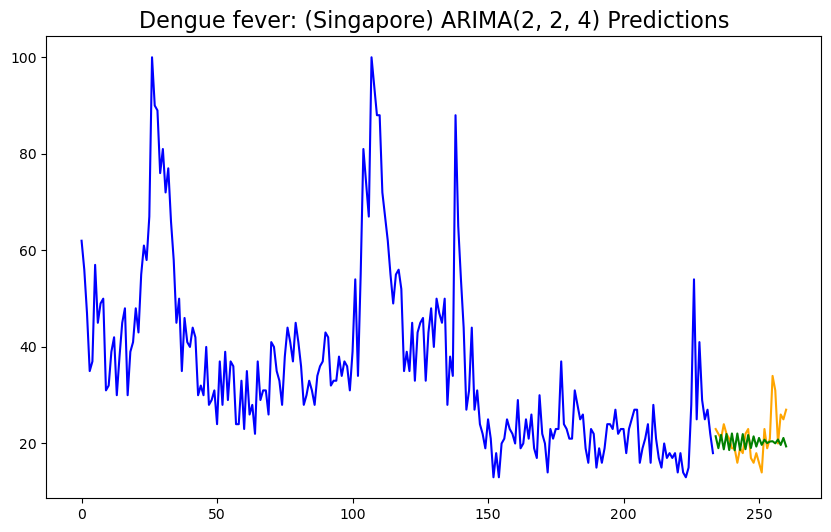

In [47]:
# Instantiate best model.
arima = ARIMA(endog=y_train, order=(2, 1, 3))

# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set.
preds = model.predict(start=y_test.index[0], end = y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Dengue fever: (Singapore) ARIMA(2, 2, 4) Predictions', fontsize=16)
plt.show();

In [40]:
y_train.tail()

229    29
230    25
231    27
232    22
233    18
Name: Dengue fever: (Singapore), dtype: int64

In [41]:
y_test.tail()

256    31
257    20
258    26
259    25
260    27
Name: Dengue fever: (Singapore), dtype: int64

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60862D+00    |proj g|=  6.85377D-02

At iterate    5    f=  3.60399D+00    |proj g|=  9.76749D-03

At iterate   10    f=  3.60160D+00    |proj g|=  8.18351D-03

At iterate   15    f=  3.60121D+00    |proj g|=  2.20932D-03

At iterate   20    f=  3.60113D+00    |proj g|=  2.15068D-03

At iterate   25    f=  3.59981D+00    |proj g|=  1.80974D-02

At iterate   30    f=  3.59476D+00    |proj g|=  8.41405D-03

At iterate   35    f=  3.59090D+00    |proj g|=  9.49570D-03

At iterate   40    f=  3.58888D+00    |proj g|=  8.73738D-03

At iterate   45    f=  3.58757D+00    |proj g|=  3.27861D-03

At iterate   50    f=  3.58722D+00    |proj g|=  7.22747D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


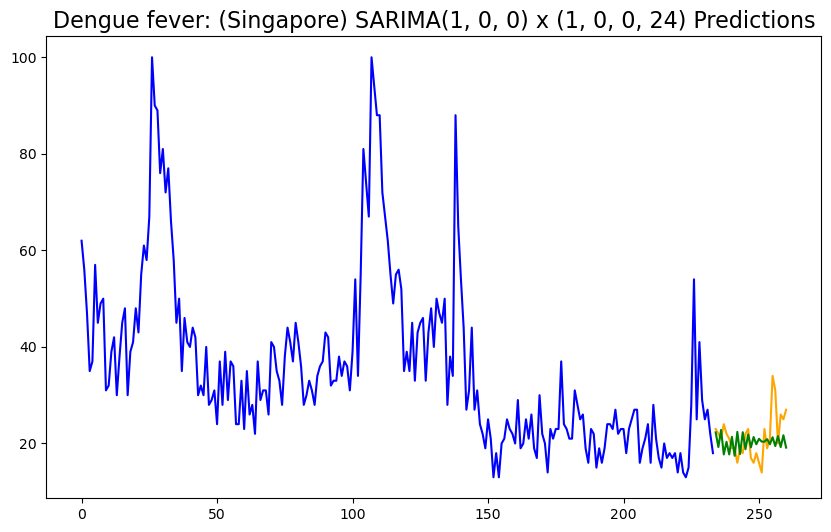

In [48]:
# Fit a SARIMA(1, 0, 0) x (1, 0, 0, 16) model.

sarima = SARIMAX(endog = y_train,
                 order = (2, 1, 3),              # (p, d, q)
                 seasonal_order = (1, 0, 0, 12)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 234 and end at 260.
preds = model.predict(start=234, end=260)

# Evaluate predictions.
print(mean_squared_error(y_test, preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Dengue fever: (Singapore) SARIMA(1, 0, 0) x (1, 0, 0, 24) Predictions', fontsize=16)
plt.show();

In [49]:
# Create train-test split.
y_train, y_test = train_test_split(df['Dengue fever: (Singapore)diff'], test_size=.1, shuffle=False)

In [50]:
grid_ARIMA(y_train, ini_i=1)

Attempting ARIMA(0, 1, 0)
The AIC for ARIMA(0,1,0) is: 1950.3081542031875
Attempting ARIMA(0, 1, 1)
The AIC for ARIMA(0,1,1) is: 1733.7267345531773
Attempting ARIMA(0, 1, 2)
The AIC for ARIMA(0,1,2) is: 1709.4484340654333
Attempting ARIMA(0, 1, 3)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(0,1,3) is: 1711.4468259421633
Attempting ARIMA(0, 1, 4)
The AIC for ARIMA(0,1,4) is: 1713.4372823967371
Attempting ARIMA(1, 1, 0)
The AIC for ARIMA(1,1,0) is: 1838.2062266359028
Attempting ARIMA(1, 1, 1)
The AIC for ARIMA(1,1,1) is: 1712.1478780171765
Attempting ARIMA(1, 1, 2)
The AIC for ARIMA(1,1,2) is: 1711.446623897265
Attempting ARIMA(1, 1, 3)
The AIC for ARIMA(1,1,3) is: 1711.5535647133447
Attempting ARIMA(1, 1, 4)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

The AIC for ARIMA(1,1,4) is: 1712.9284694232845
Attempting ARIMA(2, 1, 0)
The AIC for ARIMA(2,1,0) is: 1796.8240780673968
Attempting ARIMA(2, 1, 1)
The AIC for ARIMA(2,1,1) is: 1711.989797308158
Attempting ARIMA(2, 1, 2)
The AIC for ARIMA(2,1,2) is: 1715.2372458069717
Attempting ARIMA(2, 1, 3)
The AIC for ARIMA(2,1,3) is: 1713.1209280213595
Attempting ARIMA(2, 1, 4)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(2,1,4) is: 1709.2746147929095
Attempting ARIMA(3, 1, 0)
The AIC for ARIMA(3,1,0) is: 1768.0808861211967
Attempting ARIMA(3, 1, 1)
The AIC for ARIMA(3,1,1) is: 1713.195105227856
Attempting ARIMA(3, 1, 2)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,2) is: 1712.1122564335542
Attempting ARIMA(3, 1, 3)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,3) is: 1714.0193094541164
Attempting ARIMA(3, 1, 4)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,4) is: 1711.2666037140589
Attempting ARIMA(4, 1, 0)
The AIC for ARIMA(4,1,0) is: 1763.0727212768873
Attempting ARIMA(4, 1, 1)
The AIC for ARIMA(4,1,1) is: 1714.9792718058338
Attempting ARIMA(4, 1, 2)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,2) is: 1714.0313355337973
Attempting ARIMA(4, 1, 3)


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The AIC for ARIMA(4,1,3) is: 1715.8082525264276
Attempting ARIMA(4, 1, 4)
The AIC for ARIMA(4,1,4) is: 1721.032233540141


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(2,1,4).
This model has an AIC of 1709.2746147929095.


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


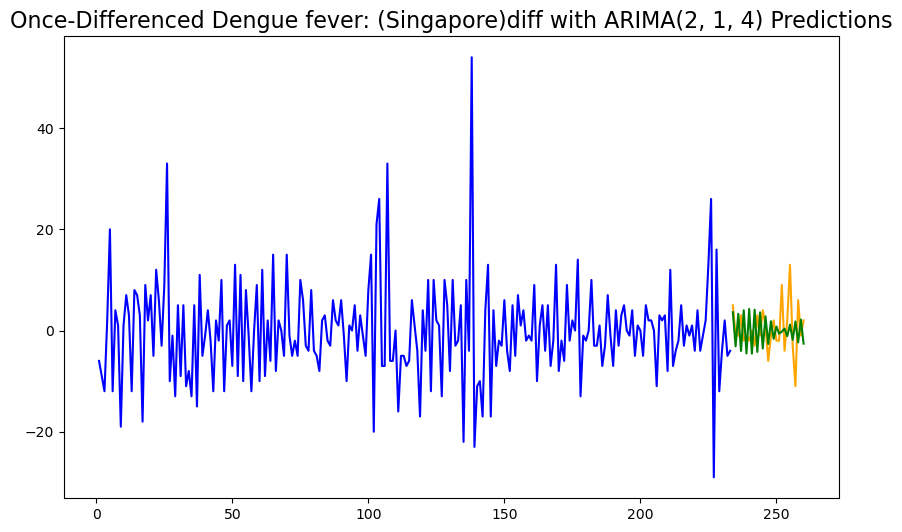

In [51]:
# Instantiate best model.
arima = ARIMA(endog=y_train, order=(2, 1, 4))

# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set.
preds = model.predict(start=y_test.index[0], end = y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Once-Differenced Dengue fever: (Singapore)diff with ARIMA(2, 1, 4) Predictions', fontsize=16)
plt.show();

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67333D+00    |proj g|=  2.94997D-02

At iterate    5    f=  3.63596D+00    |proj g|=  1.85406D-02


 This problem is unconstrained.



At iterate   10    f=  3.62872D+00    |proj g|=  1.17224D-03

At iterate   15    f=  3.62791D+00    |proj g|=  7.23356D-03

At iterate   20    f=  3.62636D+00    |proj g|=  5.01565D-03

At iterate   25    f=  3.62408D+00    |proj g|=  3.56833D-03

At iterate   30    f=  3.62277D+00    |proj g|=  8.18608D-03

At iterate   35    f=  3.62231D+00    |proj g|=  2.50543D-03

At iterate   40    f=  3.62182D+00    |proj g|=  2.89540D-03

At iterate   45    f=  3.62171D+00    |proj g|=  3.03921D-03

At iterate   50    f=  3.62169D+00    |proj g|=  3.30207D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62   

/home/zhiming/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


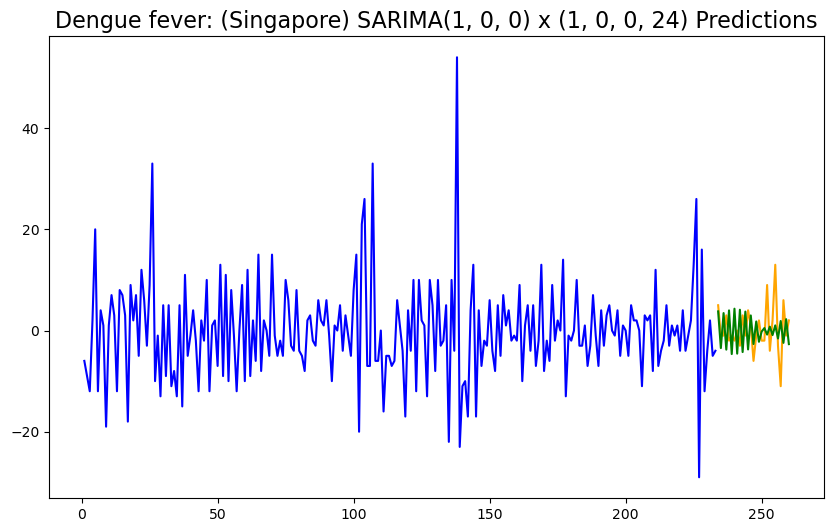

In [52]:
# Fit a SARIMA(1, 0, 0) x (1, 0, 0, 16) model.

sarima = SARIMAX(endog = y_train,
                 order = (2, 1, 4),              # (p, d, q)
                 seasonal_order = (1, 0, 0, 24)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 234 and end at 260.
preds = model.predict(start=234, end=260)

# Evaluate predictions.
print(mean_squared_error(y_test, preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Dengue fever: (Singapore) SARIMA(1, 0, 0) x (1, 0, 0, 24) Predictions', fontsize=16)
plt.show();

In [ ]:
# Generate autocorrelation plot on training data.
plot_acf(df['Dengue fever: (Singapore)'], lags = 52);

## LSTM?

In [77]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout

In [61]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler

In [54]:
X=df['Dengue fever: (Singapore)']

In [63]:
X_train, X_test = train_test_split(df['Dengue fever: (Singapore)'], shuffle=False, test_size=0.2)

In [55]:
def prep_data(data, time_periods=10, test_size=0.2):
    X = data
    # Set window of past points for LSTM model
    window = 10
    # Split 80/20 into train/test data
    X_train, X_test = train_test_split(X, shuffle=False, test_size=test_size)
    # turn 
    train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
    return x_in

In [66]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_sc = ss.transform(np.array(X_test).reshape(-1, 1))

In [69]:
train_sequences = TimeseriesGenerator(X_train_sc, X_train_sc, length=10, batch_size=64)

In [71]:
batch_x, batch_y = train_sequences[0]

In [73]:
test_sequences = TimeseriesGenerator(X_test_sc, X_test_sc, length=10, batch_size=64)

In [75]:
input_shape = train_sequences[0][0][0].shape

In [81]:
from tensorflow.keras.optimizers import Adam

In [87]:
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
m.add(Dropout(0.2))
m.add(LSTM(units=50, return_sequences=False, input_shape=input_shape))
m.add(Dropout(0.2))
m.add(Dense(units=4, activation='relu'))
m.add(Dense(units=1))
m.compile(optimizer = Adam(learning_rate=.0005), loss = 'mean_squared_error', metrics=['acc'])

2023-04-08 17:31:50.245095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-08 17:31:50.246600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-08 17:31:50.247864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-04-08 16:02:37.691003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-08 16:02:37.824085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-08 16:02:37.825207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

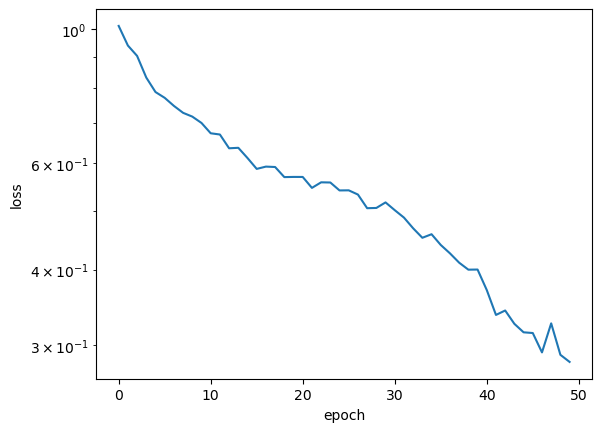

In [85]:
# Fit LSTM model
history = m.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

plt.figure()
plt.ylabel('loss'); plt.xlabel('epoch')
plt.semilogy(history.history['loss'])

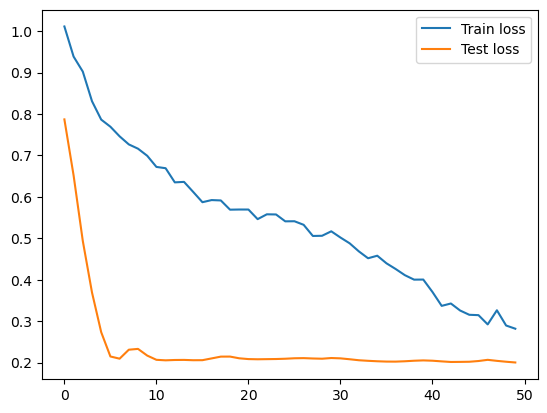

In [86]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend();